In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
sales_train_validation = pd.read_csv('./Walmart Data/sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('./Walmart Data/sales_train_evaluation.csv')
sell_prices = pd.read_csv('./Walmart Data/sell_prices.csv')
calendar = pd.read_csv('./Walmart Data/calendar.csv')
sample_submission = pd.read_csv('./Walmart Data/sample_submission.csv')

In [3]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [4]:
calendar['combined_event_type'] = calendar.apply(
    lambda row: row['event_type_1'] if pd.isnull(row['event_type_2'])
    else row['event_type_1'] + ' & ' + row['event_type_2'],
    axis=1
)

In [5]:
'''Data pre-processing'''

'Data pre-processing'

In [5]:
item_category_sales = sales_train_validation.groupby(['item_id', 'cat_id']).sum().iloc[:, -1913:].sum(axis=1).reset_index()

item_category_sales.columns = ['item_id', 'cat_id', 'total_sales']

top_10_per_category = item_category_sales.sort_values(['cat_id', 'total_sales'], ascending=[True, False]).groupby('cat_id').head(10)

sales_train_validation = sales_train_validation.loc[sales_train_validation['item_id'].isin(top_10_per_category['item_id'])]
sales_train_evaluation = sales_train_evaluation.loc[sales_train_evaluation['item_id'].isin(top_10_per_category['item_id'])]

In [6]:
# Melt sales data to long format
sales_train_validation = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')

sales_train_validation['day'] = sales_train_validation['day'].apply(lambda x: x[2:]).astype(int)
data = pd.merge(sales_train_validation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
data['date'] = pd.to_datetime(data['date'])

data = pd.merge(data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [7]:
#Same for Evaluation Dataset
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_evaluation['day'] = sales_train_evaluation['day'].apply(lambda x: x[2:]).astype(int)
eval_data = pd.merge(sales_train_evaluation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
eval_data['date'] = pd.to_datetime(eval_data['date'])
eval_data = pd.merge(eval_data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [8]:
event_columns = [col for col in data.columns if 'event' in col]

data['is_event_or_holiday'] = data[event_columns].any(axis=1)
eval_data['is_event_or_holiday'] = eval_data[event_columns].any(axis=1)

In [9]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data['weekday'] = pd.Categorical(data['weekday'], categories=days_order, ordered=True)
eval_data['weekday'] = pd.Categorical(eval_data['weekday'], categories=days_order, ordered=True)

In [10]:
data.sort_values(by=['id', 'date'], inplace=True)
eval_data.sort_values(by=['id', 'date'], inplace=True)

In [ ]:
''' Group and Create Lagged Features
data['sales_lag_1'] = data.groupby(['id'])['sales'].shift(1)
data['sales_lag_7'] = data.groupby(['id'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['id'])['sales'].shift(30)

eval_data['sales_lag_1'] = eval_data.groupby(['id'])['sales'].shift(1)
eval_data['sales_lag_7'] = eval_data.groupby(['id'])['sales'].shift(7)
eval_data['sales_lag_30'] = eval_data.groupby(['id'])['sales'].shift(30)

data['sales_rolling_mean_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
data['sales_rolling_mean_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
data['sales_rolling_std_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
data['sales_rolling_std_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

eval_data['sales_rolling_mean_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
eval_data['sales_rolling_mean_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
eval_data['sales_rolling_std_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
eval_data['sales_rolling_std_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

chunk_size = 100000
num_chunks = len(data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

data = pd.concat(processed_data, ignore_index=True)

chunk_size = 100000
num_chunks = len(eval_data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = eval_data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

eval_data = pd.concat(processed_data, ignore_index=True)

'''

In [11]:
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week
data['start_of_month'] = (data['date'].dt.day == 1).astype(int)
data['is_august'] = (data['month'] == 8).astype(int)
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

In [12]:
eval_data['day_of_week'] = eval_data['date'].dt.dayofweek
eval_data['week_of_year'] = eval_data['date'].dt.isocalendar().week
eval_data['start_of_month'] = (eval_data['date'].dt.day == 1).astype(int)
eval_data['is_august'] = (eval_data['month'] == 8).astype(int)
eval_data['is_weekend'] = (eval_data['day_of_week'] >= 5).astype(int)

In [13]:
data['snap_CA_sales'] = np.where(data['state_id'] == 'CA', data['snap_CA'] * data['sales'], 0)
data['snap_TX_sales'] = np.where(data['state_id'] == 'TX', data['snap_TX'] * data['sales'], 0)
data['snap_WI_sales'] = np.where(data['state_id'] == 'WI', data['snap_WI'] * data['sales'], 0)

In [14]:
eval_data['snap_CA_sales'] = np.where(eval_data['state_id'] == 'CA', eval_data['snap_CA'] * eval_data['sales'], 0)
eval_data['snap_TX_sales'] = np.where(eval_data['state_id'] == 'TX', eval_data['snap_TX'] * eval_data['sales'], 0)
eval_data['snap_WI_sales'] = np.where(eval_data['state_id'] == 'WI', eval_data['snap_WI'] * eval_data['sales'], 0)

In [15]:
data['snap'] = 0

data.loc[data['state_id'] == 'CA', 'snap'] = data['snap_CA']
data.loc[data['state_id'] == 'TX', 'snap'] = data['snap_TX']
data.loc[data['state_id'] == 'WI', 'snap'] = data['snap_WI']

In [16]:
eval_data['snap'] = 0

eval_data.loc[eval_data['state_id'] == 'CA', 'snap'] = eval_data['snap_CA']
eval_data.loc[eval_data['state_id'] == 'TX', 'snap'] = eval_data['snap_TX']
eval_data.loc[eval_data['state_id'] == 'WI', 'snap'] = eval_data['snap_WI']

In [17]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

In [18]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    eval_data[col] = eval_data[col].astype('category').cat.codes

In [26]:
'''SARIMA Model'''

'SARIMA Model'

In [19]:
eval_data = eval_data.groupby('id').apply(lambda x: x.tail(28))
eval_data.reset_index(drop=True, inplace=True)

In [51]:
def dickey_fuller_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is non-stationary")

dickey_fuller_test(data['sales'])

KeyboardInterrupt: 

In [20]:
unique_products = data['id'].unique()

results_df = pd.DataFrame(columns=['date', 'id', 'actual', 'predicted'])

all_future_forecasts = []

for product in unique_products:
    product_data = data[data['id'] == product]
    
    train = product_data.iloc[:-180]
    valid = product_data.iloc[-180:]
    
    model = SARIMAX(train['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 28))
    model_fit = model.fit(disp=False)
    
    forecast = model_fit.get_forecast(steps=180)
    predicted_values = forecast.predicted_mean
    
    temp_df = pd.DataFrame({
        'date': valid['date'].values,
        'id': product,
        'actual': valid['sales'].values,
        'predicted': predicted_values.values
    })
    
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    future_forecast = model_fit.get_forecast(steps=180+28)
    future_predicted_values = future_forecast.predicted_mean[-28:]
    
    future_dates = pd.date_range(start=valid['date'].values[-1], periods=29, freq='D')[1:]
    
    future_temp_df = pd.DataFrame({
        'date': future_dates,
        'id': product,
        'actual': [None] * 28,
        'predicted': future_predicted_values.values
    })
    
    all_future_forecasts.append(future_temp_df)

all_future_forecasts_df = pd.concat(all_future_forecasts, ignore_index=True)

print(results_df)
print(all_future_forecasts_df)

c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index w

            date   id actual  predicted
0     2015-10-28    0     40  44.514707
1     2015-10-29    0     58  45.329810
2     2015-10-30    0     77  63.785927
3     2015-10-31    0    101  80.570514
4     2015-11-01    0     58  74.025346
...          ...  ...    ...        ...
53995 2016-04-20  299      2   9.244288
53996 2016-04-21  299      2  10.111103
53997 2016-04-22  299      1  11.487004
53998 2016-04-23  299      7  12.740659
53999 2016-04-24  299      5  12.119270

[54000 rows x 4 columns]
           date   id actual  predicted
0    2016-04-25    0   None  42.199289
1    2016-04-26    0   None  34.997204
2    2016-04-27    0   None  36.052217
3    2016-04-28    0   None  37.389180
4    2016-04-29    0   None  63.884267
...         ...  ...    ...        ...
8395 2016-05-18  299   None   9.350410
8396 2016-05-19  299   None  10.217225
8397 2016-05-20  299   None  11.593126
8398 2016-05-21  299   None  12.846782
8399 2016-05-22  299   None  12.225392

[8400 rows x 4 columns]


c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
mae = mean_absolute_error(valid['sales'], predicted_values)
mse = mean_squared_error(valid['sales'], predicted_values)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 4.9331146373233725
MSE: 32.35260897993265
RMSE: 5.6879353881643775


In [22]:
all_future_forecasts_df['actual'] = eval_data['sales']

In [23]:
mae = mean_absolute_error(valid['sales'], predicted_values)
mse = mean_squared_error(valid['sales'], predicted_values)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 4.9331146373233725
MSE: 32.35260897993265
RMSE: 5.6879353881643775


In [24]:
grouped_eval_data = data.groupby('date')['sales'].sum().reset_index()
grouped_eval_data.columns = ['date', 'actual_sales']
grouped_predicted_data = results_df.groupby('date')['predicted'].sum().reset_index()

In [25]:
merged_data = pd.merge(grouped_predicted_data, grouped_eval_data, on='date', how='left')

In [26]:
future_predict_data = all_future_forecasts_df.groupby('date')[['predicted','actual']].sum().reset_index()

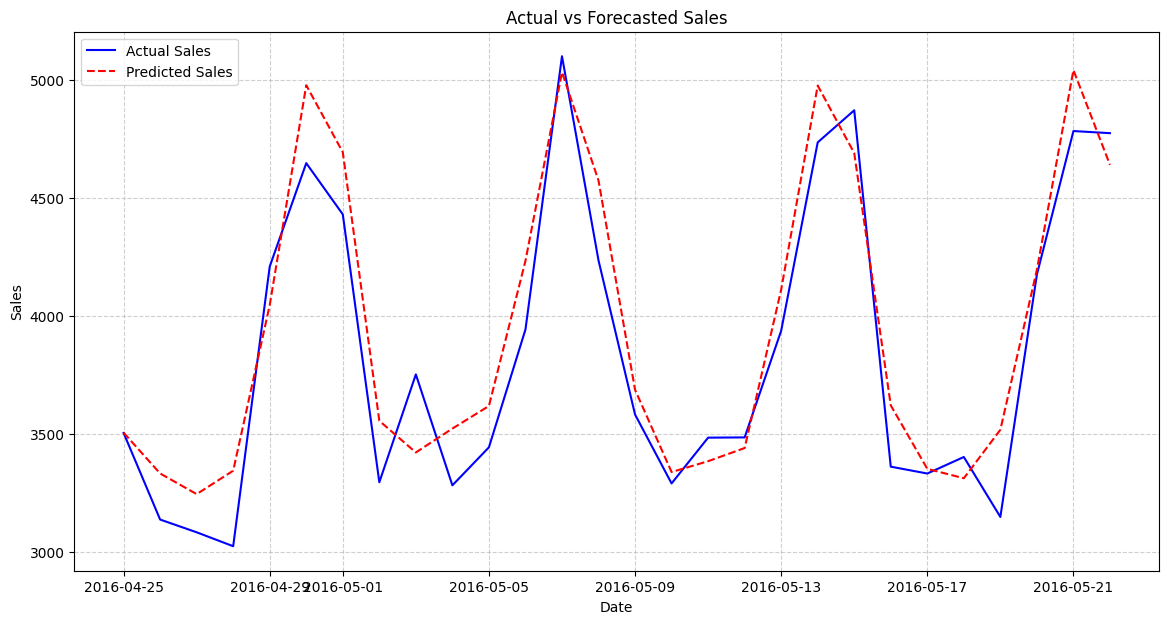

In [27]:
plt.figure(figsize=(14, 7))

plt.plot(future_predict_data['date'], future_predict_data['actual'], label='Actual Sales', color='blue')
plt.plot(future_predict_data['date'], future_predict_data['predicted'], label='Predicted Sales', color='red', linestyle='--')

plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [29]:
results_df.to_excel('SARIMA_results.xlsx')
all_future_forecasts_df.to_excel('SARIMA_results_28.xlsx')